# Demo 1: Linear Regression

In this demo we will show:
* Linear regression using gradient descent, stochastic gradient descent, and mini-batch gradient descent. 
* Heuristics/Scheduling to modify the gradient descent learning rate. 
* Gradient descent to minimize other (non-convex) functions. 

In [2]:
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from util import gradient_descent, generate_polynomial_data
import plot_helpers
import IPython 

import ipywidgets
from ipywidgets import interact, interactive, interact_manual

import pylab
pylab.rcParams['figure.figsize'] = (10, 5)

from regressors import LinearRegressor
from regularizers import Regularizer, L2Regularizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will start by fitting points generated by a linear function with some additive white gaussian noise. That is, the data will be of the type $D = \left\{(x, y)_i\right\}$, $i = 1, 2, \ldots, N$, where $$y = a^\top x + b + \epsilon.$$

The objective of linear regression, is to find coefficents $(\hat{a}, \hat{b})$ such that the error between $\hat{y} = \hat{a}^\top x + \hat{b}$, and $y$ is small.  

The loss function is defined as: $$ L = \mathbb{E}[\frac{1}{2}(\hat{y}-y)^2)],$$
where the expectation is taken over the data generating distribution. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The loss is approximated as:
$$ L(x, y) \approx \frac{1}{N}\sum_{i=1}^N L(x_i, y_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2}(\hat{y}_i-y_i)^2.$$ 

Replacing the expression for $\hat{y} = \hat{a}^\top x + \hat{b}$ into the loss:
$$ L(x, y) \approx \frac{1}{N}\sum_{i=1}^N \frac{1}{2}(\hat{a}x_i+\hat{b}-y_i)^2.$$

The parameters $\hat{a}$ and $\hat{b}$ will be grouped into a single vector $\hat{w} = [\hat{a}, \hat{b}]$ and the data will be grouped into the feature matrix $X$ and target matrix $Y$, such that:

$$ X = \left[ \begin{array}{cc} x_1^\top & 1\\ x_2^\top & 1 \\ \vdots & \vdots \\ x_N^\top & 1  \end{array}\right]$$
$$ Y = \left[ \begin{array}{c} y_1\\ y_2 \\ \vdots \\ y_N  \end{array}\right].$$ 

The loss function can be expressed as:
$$ L(x, y) \approx \frac{1}{N}(Xw - Y)^\top (Xw - Y) $$

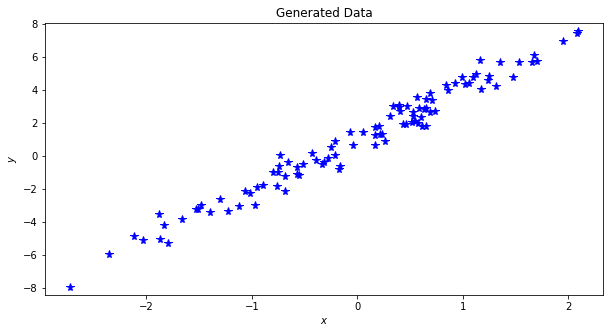

In [2]:
num_points = 100  # Number of training points.
noise = 0.6  # Noise Level (needed for data generation).

a_true = 3  # Slope.
b_true = 1  # Intercept. 
w_true = np.array([a_true, b_true])

X, Y = generate_polynomial_data(num_points, noise, w_true)

# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)


## Closed Form Solution:

The closed form solution to the regression problem is given by:
$$\hat{w} = (X^\top X)^{-1} X^T y.$$ 

Because there are only 2 parameters, the inverse of $X^\top X$ is fast to do $\approx O(d^3)$. Hence, the closed form can be computed with a total number of operations given by $\approx O(d^3+nd^2)$ .

In [3]:
def change_reg_coefficient(reg):
    dim = X.shape[1]
    w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X.T, X) + np.power(10., reg) * np.eye(dim)), np.dot(X.T, Y))
    print("w_hat = {}".format(w_hat_closed_form))
    # Plot closed form solution
    fig = plt.subplot(111)
    plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
                 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}

    plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)
    plot_helpers.plot_fit(X, w_hat_closed_form, fig=fig, options=plot_opts)

interact(change_reg_coefficient,
         reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False));


interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

## Gradient Descent Algorithm:

When the number of dimensions or examples grows, the closed form solution becomes expensive to compute. Hence, the parameters $\hat{w}$ can be updated via a gradient descent rule: 

$$ \hat{w}_{k+1} \gets \hat{w}_k - \eta_k \left.\frac{\partial L}{\partial w} \right|_{w=w_k},$$

where $\eta_k$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial L}{\partial w}$

The gradients of L with respect to the parameters are:

$$ \frac{\partial L}{\partial \hat{w}} = \frac{1}{N} X^\top(Xw - y) $$ 
In the *vanilla* gradient descent method, $\eta(k)=\eta_0$ is a constant. However other algorithms exists that modify this. We will discuss these later. 

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 

In [4]:
def change_learning_params(eta0, n_iter, reg=0):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(np.power(10., reg))
    w0 = np.array([0., 0.])
    opts = {'eta0': eta0, 'n_iter': n_iter, 'n_samples': X.shape[0]}
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False,
                   }
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False, 
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': False}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_learning_params,
                eta0=ipywidgets.FloatSlider(value=1e-1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=20,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                reg=ipywidgets.FloatSlider(value=-3,
                                           min=-3,
                                           max=1,
                                           step=0.5,
                                           readout_format='.2f',
                                           description='Regularization 10^:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                );


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=20, min=5, style=SliderStyle(description_width='initial')), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=1.0, min=-3.0, step=0.5, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Stochastic Gradient Descent:

To compute the gradient in stochastic descent, the gradient for each data point must be individually computed and then add them up together. However, each of the data points provides an unbiased estimate (albiet with higher variance) of the expected value of the gradient, i. e.

$$ \mathbb{E}\left[\frac{\partial L(x,y)}{\partial \hat{w}}\right] \approx \frac{\partial L(x_i, y_i)}{\partial \hat{w}} = x_i (x_i^\top \hat{w} - y_i). $$ 

As the gradient depends only on one sample, it is much more noisy and more iterations are needed for convergence. The computational complexity is $O(n_{\text{iter}} \cdot d)$. 

As each gradient step contains significant noise, a desirable property of the algorithm is that the learning rate becomes smaller as it is closer to convergence. If the sequence $eta_k$ satisfy Robbins-Monro condtion,  $\sum_{k=0}^\infty eta_k = \infty$, $\sum_{k=0}^\infty eta_k^2 < \infty$ then stochastic gradient descent is guaranteed to converge. For example $\eta_k = \frac{\eta_0}{(k+1)^{0.6}}$ satisfy this requirements. 

In [8]:
def change_learning_params(eta0, n_iter, reg, annealing):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(np.power(10., reg))
    w0 = np.array([0., 0.])
    if annealing:
        learning_rate_scheduling = 'Annealing'
    else:
        learning_rate_scheduling = None

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'n_samples': X.shape[0],
            'learning_rate_scheduling': learning_rate_scheduling,
            'algorithm': 'SGD'
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': True}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(change_learning_params,
                eta0=ipywidgets.FloatSlider(value=1e-1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=20,
                                            min=5,
                                            max=200,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                reg=ipywidgets.FloatSlider(value=-3,
                                           min=-3,
                                           max=1,
                                           step=0.5,
                                           readout_format='.2f',
                                           description='Regularization 10^:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                annealing=False);


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=20, continuous_update=False, description='Number of iterations:', max=200, min=5, style=SliderStyle(description_width='initial')), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=1.0, min=-3.0, step=0.5, style=SliderStyle(description_width='initial')), Checkbox(value=False, description='annealing'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Mini-batch Gradient Descent:

A trade-off between full gradient descent (higher cost, lower variance), and stochastic gradient descent (lower cost, higher variance), is done by computing the gradient of a mini-batch of points i.e.
$$ \mathbb{E}\left[\frac{\partial L(x,y)}{\partial \hat{w}}\right] \approx \frac{1}{|B|} \sum_{i\in B} \frac{\partial L(x_i, y_i)}{\partial \hat{w}} = \frac{1}{|B|} \sum_{i\in B} x_i (x_i^\top \hat{w} - y_i). $$ 

The computational complexity is $O(n_{\text{iter}} \cdot |B| d)$. 

In [5]:
def change_batch_size(batch_size):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(0)
    w0 = np.array([0., 0.])

    opts = {'eta0': 1e-1,
            'n_iter': 20,
            'batch_size': batch_size,
            'n_samples': X.shape[0],
            'algorithm': 'SGD'
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': True}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_batch_size,
                batch_size=ipywidgets.IntSlider(value=32,
                                                min=1,
                                                max=100,
                                                step=1,
                                                description='Batch Size:',
                                                style={'description_width': 'initial'},
                                                continuous_update=False),
                );


interactive(children=(IntSlider(value=32, continuous_update=False, description='Batch Size:', min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Other Heuristics 

* Bold driver heuristic:

    If $L(x, y, w_k) > L(x, y, w_{k+1})$, 
    
    $\eta_{k+1} = \eta_{k}/5$
    
    else
    
    $\eta_{k+1} \gets \eta_{k}*1.1$

    
* AdaGrad:
    $\eta_k = \frac{\eta_0}{\sqrt{\sum_{j=0}^k g_j^2}}$, where $g_j$ is the 2-norm gradient of $L$ at time $j$. 

       
        


In [10]:
def change_heuristics(learning_rate_scheduling=None):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(0)
    w0 = np.array([0., 0.])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': 2,
            'n_iter': 10,
            'batch_size': 1,
            'n_samples': X.shape[0],
            'algorithm': 'GD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_heuristics,
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='Bold driver',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'})
                );

#gradient_descent(X, Y, w0, L, gradL, n_iter=10, eta0=3, plot=True, learning_rate_scheduling='AdaGrad')


interactive(children=(RadioButtons(description='Learning rate heuristics:', options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='Bold driver'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Gradient descent for other functions

Gradient descent works well for other functions, even if they are non-convex; gradient descent, if it converges, converges to a local minimum. Lets look at the function $$f(a,b) = \sin(a)\cos(b).$$ We would like to find parameters $(a,b)$ that minimize the function $f$. 

The gradients are:
$$\frac{\partial f}{\partial a} = \cos(a)\cos(b),$$
$$\frac{\partial f}{\partial b} = -\sin(a)\sin(b).$$

In [11]:
class sincos(object):
    def __init__(self):
        pass

    def get_number_samples(self):
        return 0

    def loss(self, w, *args):
        return np.sin(w[0]) * np.cos(w[1])

    def gradient(self, w, *args):
        return np.array([np.cos(w[0]) * np.cos(w[1]), -np.sin(w[0]) * np.sin(w[1])])

def optimize_sincos(eta, n_iter, learning_rate_scheduling, a0, b0):
    regressor = sincos()
    regularizer = L2Regularizer(0)
    w0 = np.array([a0, b0])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': eta,
            'n_iter': n_iter,
            'batch_size': 1,
            'n_samples': 0,
            'algorithm': 'GD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(111)
    dataplot = None
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    plot_opts = {'contour_opts': contour_opts}

    plot_helpers.linear_regression_progression(np.array([]), np.array([]), trajectory, indexes, regressor.loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(optimize_sincos,
                eta=ipywidgets.FloatSlider(value=4,
                                           min=1e-1,
                                           max=10,
                                           step=1e-1,
                                           readout_format='.1f',
                                           description='Learning rate:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='None',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'}),
                a0=ipywidgets.FloatSlider(value=-0.9,
                                          min=-3,
                                          max=3,
                                          step=.1,
                                          readout_format='.1f',
                                          description='w_0:',
                                          style={'description_width': 'initial'},
                                          continuous_update=False),
                b0=ipywidgets.FloatSlider(value=1.1,
                                          min=-3,
                                          max=3,
                                          step=.1,
                                          readout_format='.1f',
                                          description='w_1:',
                                          style={'description_width': 'initial'},
                                          continuous_update=False));

#gradient_descent(np.array([]), np.array([]), np.array([-1,2.5]), fsincos, grad_fsincos, n_iter=10, eta0=1, plot=True)


interactive(children=(FloatSlider(value=4.0, continuous_update=False, description='Learning rate:', max=10.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), RadioButtons(description='Learning rate heuristics:', index=3, options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='None'), FloatSlider(value=-0.9, continuous_update=False, description='w_0:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), FloatSlider(value=1.1, continuous_update=False, description='w_1:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Higher order linear regression

Suppose the data is generated by $y = ax^3 + bx^2 + cx + d + \epsilon $. Even if $y$ is non-linear on the features $x$, it is linear in the parameters $w = (a,b,c,d)$. The data and target matrices can be constructed as: 

$$ X = \left[ \begin{array}{cccc} x_1^3 & x_1^2 & x_1 & 1\\ x_2^3 & x_2^2 & x_2 & 1 \\ \vdots & \vdots \\ x_N^3 & x_N^2 & x_N & 1  \end{array}\right]$$
$$ Y = \left[ \begin{array}{c} y_1\\ y_2 \\ \vdots \\ y_N  \end{array}\right].$$ 

In [3]:
num_points = 100  # Number of training points.
noise = 0.3  # Noise Level (needed for data generation).

w_true = np.array([-.5, .5, 1, -1])
X, Y = generate_polynomial_data(num_points, noise, w_true)


def change_reg_coefficient(reg):
    dim = X.shape[1]
    w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X.T, X) + np.power(10., reg) * np.eye(dim)), np.dot(X.T, Y))
    # 

    # Plot closed form solution
    fig = plt.subplot(111)
    plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True, 
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_helpers.plot_data(X[:, -2], Y, fig=fig, options=plot_opts)
    plot_helpers.plot_fit(X, w_hat_closed_form, fig=fig, options=plot_opts)
    
    print("w_hat = {}".format(w_hat_closed_form))

interact(change_reg_coefficient,
         reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False));


interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

In [4]:
def optimize_cubic(eta, n_iter, reg, batch_size, learning_rate_scheduling):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(np.power(10., reg))
    w0 = np.array([0., 0., 0., 0.])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': eta,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = None
    dataplot = plt.subplot(111)
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5], 'sgd_point': True}
    plot_opts = {'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(optimize_cubic,
                eta=ipywidgets.FloatSlider(value=1e-2,
                                           min=1e-3,
                                           max=1,
                                           step=1e-3,
                                           readout_format='.3f',
                                           description='Learning rate:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                reg=ipywidgets.FloatSlider(value=-3,
                                           min=-3,
                                           max=3,
                                           step=0.5,
                                           readout_format='.1f',
                                           description='Regularization 10^:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=32,
                                                min=1,
                                                max=X.shape[0],
                                                step=1,
                                                description='Batch size:',
                                                style={'description_width': 'initial'},
                                                continuous_update=False),
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='None',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'})
                );


interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Learning rate:', max=1.0, min=0.001, readout_format='.3f', step=0.001, style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), IntSlider(value=32, continuous_update=False, description='Batch size:', min=1, style=SliderStyle(description_width='initial')), RadioButtons(description='Learning rate heuristics:', index=3, options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='None'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Using a ML Library on Real-Life Datasets 

The sklearn library has a lot of implemented ML algorithms as well as real-life datasets. 

In [5]:
import sklearn
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

def f(x):
    return x * np.sin(x) 

x_plot = np.linspace(-1, 11, 100)
f_plot = f(x_plot)
X_plot = x_plot[:, np.newaxis]


In [6]:
def resample(noise):

    xraw = np.linspace(0, 10, 100)
    np.random.shuffle(xraw)
    
    x = (xraw[:20])

    y = f(x)+ np.random.normal(size=(20,)) * noise

    # create matrix versions of these arrays
    X = x[:, np.newaxis]

    def change_degree(degree, reg):
        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=np.power(10., reg)))
        model.fit(X, y)
        
        fig = plt.subplot(111)
        lw = 2
        plt.plot(x_plot, f_plot, color='cornflowerblue', linewidth=lw, label="Ground Truth")
        y_plot = model.predict(X_plot)
        plt.plot(x_plot, y_plot, color='r', linewidth=lw, label="Degree %d" % degree)
        
        plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':True, 'legend_loc': 'lower left'}
        
        opts = {'marker': 'b*', 'label': 'Training Points'}
        plot_opts.update(opts)
        
        plot_helpers.plot_data(X, y, fig=fig, options=plot_opts)
        
        coefs = model._final_estimator.coef_
        coefs[0] = model._final_estimator.intercept_
        print("Estimated coefficients{}".format(coefs))
        

    interact(change_degree,
             degree=ipywidgets.IntSlider(value=1,
                                         min=1,
                                         max=20,
                                         step=1,
                                         description='Polynomial Degree:',
                                         style={'description_width': 'initial'},
                                         continuous_update=False),
            reg=ipywidgets.FloatSlider(value=-3,
                                               min=-3,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Regularization 10^:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),);

interact(resample, noise=ipywidgets.FloatSlider(value=1,
                                               min=0,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Noise level:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Noise level:', max=3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

## K-Fold Cross Validation

In [8]:
def resample(noise):
    N = 200
    folds = 5
    n = int(N/folds)

    xraw = np.linspace(0, 10, N)
    # rng = np.random.RandomState(0)
    np.random.shuffle(xraw)

    #noise=1

    x = dict()
    y = dict()
    for i in range(folds):
        x[i] = xraw[n*i:n*(i+1)]
        y[i] = f(x[i]) + np.random.normal(size=(n,)) * noise

    
    def change_degree(degree, reg, fold):
        X = np.array(())
        Y = np.array(())
        for i in range(5):
            if i == (fold-1):
                Xval = x[i]
                Yval = y[i]
            else:
                X = np.concatenate((X, x[i]))
                Y = np.concatenate((Y, y[i]))


        X = X[:, np.newaxis]
        Xval = Xval[:, np.newaxis]

        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=np.power(10., reg)))

        model.fit(X, Y)
        
        fig = plt.subplot(111)
        lw = 2
        plt.plot(x_plot, f_plot, color='cornflowerblue', linewidth=lw, label="Ground Truth")
        y_plot = model.predict(X_plot)
        plt.plot(x_plot, y_plot, color='r', linewidth=lw, label="Degree %d" % degree)
        
        opts = {'marker': 'b*', 'label': 'Training Points'}
        plot_helpers.plot_data(X, Y, fig=fig, options=opts)
        
        plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':True, 'legend_loc': 'lower left'}
        opts = {'marker': 'mX', 'label': 'Validation Points'}
        plot_opts.update(opts)
        plot_helpers.plot_data(Xval, Yval, fig=fig, options=plot_opts)
        
        print("Train. Error: {:.2f}".format(1/X.size * np.linalg.norm(model.predict(X) - Y, 2)))
        print("Valid. Error: {:.2f}".format(1/Xval.size * np.linalg.norm(model.predict(Xval) - Yval, 2)))
        
        
    interact(change_degree,
             degree=ipywidgets.IntSlider(value=1,
                                         min=1,
                                         max=15,
                                         step=1,
                                         description='Polynomial Degree:',
                                         style={'description_width': 'initial'},
                                         continuous_update=False),
             reg=ipywidgets.FloatSlider(value=-3,
                                               min=-3,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Regularization 10^:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),
             fold=ipywidgets.ToggleButtons(value=1,
                                        options=[1, 2, 3, 4, 5],
                                         description='Validation fold:',
                                         style={'description_width': 'initial'},
                                         continuous_update=False),);

interact(resample, noise=ipywidgets.FloatSlider(value=1,
                                               min=0,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Noise level:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Noise level:', max=3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

# Bias/Variance Tradeoff

Via de Regularization parameter, there exists a bias/variance tradeoff. 

In [9]:
X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

noise = 0.1

def change_reg_parameter(alpha):
    classifier = Ridge(alpha=np.power(10., alpha))
    np.random.seed(0)
    for _ in range(6):
        X_noisy = X_train + noise * np.random.randn(2, 1)
        classifier.fit(X_noisy, y_train)

        plt.plot(X_test, classifier.predict(X_test), color='.5')
        plt.scatter(X_noisy, y_train, s=3, c='.5', marker='o', zorder=10)

    classifier.fit(X_train, y_train)
    plt.plot(X_test, classifier.predict(X_test), linewidth=2, color='blue')
    plt.scatter(X_train, y_train, s=30, c='r', marker='+', zorder=10); 

interact(change_reg_parameter,
         alpha=ipywidgets.FloatSlider(value=-3,
                                     min=-3,
                                     max=1,
                                     step=0.5,
                                     description='Regularization 10^:',
                                     style={'description_width': 'initial'},
                                     continuous_update=False));

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=1.0, min=-3.0, step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

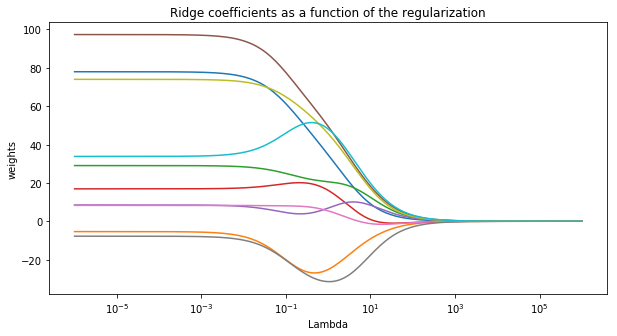

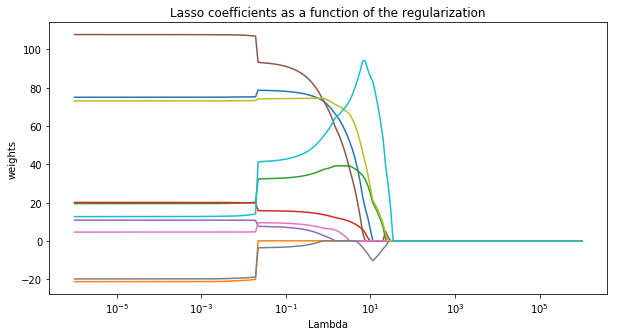

In [10]:
X, y, w = make_regression(n_samples=10, n_features=10, coef=True, random_state=1, bias=3.5)
from sklearn.linear_model import Lasso 
clfs = dict(ridge=Ridge(), lasso=Lasso())

alphas = np.logspace(-6, 6, 200)
coefs = dict(ridge=[], lasso=[])
for a in alphas:
    for name, clf in clfs.items():
        clf.set_params(alpha=a, max_iter=10000)
        clf.fit(X, y)
        coefs[name].append(clf.coef_)

fig = plt.figure(1)
plt.plot(alphas, coefs['ridge'])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

fig = plt.figure(2)
plt.plot(alphas, coefs['lasso'])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');